## Introduction

While learning NLP techniques from the ['Natural Language Processing and Computational Linguistics'](https://www.goodreads.com/book/show/40706911-beginning-natural-language-processing) book, in chapter 10, Clustering and Classifying Text, I came across an example where I learned about hierarchical clustering with cosine similarity measure and visualization with dendograms. All this seemed very complicated without trying it out myself. 

So, I thought of the following idea: I have been manually cataloguing the books I've read in [my Goodreads shelf](https://www.goodreads.com/review/list/22281793-pranjal-singh?shelf=read&sort=date_read). While the shelf customization helps me know which books I have read under each category, it is a limited understanding of how various books are related to each other.

Below I document my analysis of similarities in my books and in conclusion discuss how it lead to a visual representation of diversity and similarity in knowledge I have gathered across genres.

## Data Acquisition

I collected the titles, genres and descriptions of 16 books from my Goodreads shelf at https://www.goodreads.com/review/list/22281793-pranjal-singh?shelf=read&sort=date_read into a CSV and placed it in `data/goodreads/` directory in this repository.

Let's load it with Pandas.

In [99]:
import pandas as pd

df = pd.read_excel('data/goodreads/books.xlsx')

df.head()

,Title,Genres,Details
0,Harry Potter and the Sorcerer's Stone,Fantasy Fiction Young Adult Magic Childrens Mi...,Harry Potter has no idea how famous he is. Tha...
1,The Hound of the Baskervilles,Mystery Fiction Crime Classics Mystery Thrille...,"In this, one of the most famous of Doyle's mys..."
2,Advanced Engineering Mathematics,Mathematics Engineering,The fourth edition of this very successful boo...
3,The Diary of a Young Girl,Classics Nonfiction Biography Memoir Historica...,Discovered in the attic in which she spent the...
4,THEORY OF MECHANISMS AND MACHINES,Mechanical Engineering Automotive,Theory of Machines and Mechanisms provides the...


## Preprocessing

In [100]:
# join the information in Genres and Details together
df["Info"] = df["Genres"].astype(str) + ". " + df["Details"].astype(str)

df.head()

,Title,Genres,Details,Info
0,Harry Potter and the Sorcerer's Stone,Fantasy Fiction Young Adult Magic Childrens Mi...,Harry Potter has no idea how famous he is. Tha...,Fantasy Fiction Young Adult Magic Childrens Mi...
1,The Hound of the Baskervilles,Mystery Fiction Crime Classics Mystery Thrille...,"In this, one of the most famous of Doyle's mys...",Mystery Fiction Crime Classics Mystery Thrille...
2,Advanced Engineering Mathematics,Mathematics Engineering,The fourth edition of this very successful boo...,Mathematics Engineering. The fourth edition of...
3,The Diary of a Young Girl,Classics Nonfiction Biography Memoir Historica...,Discovered in the attic in which she spent the...,Classics Nonfiction Biography Memoir Historica...
4,THEORY OF MECHANISMS AND MACHINES,Mechanical Engineering Automotive,Theory of Machines and Mechanisms provides the...,Mechanical Engineering Automotive. Theory of M...


## Text cleanup and Lemmatization

In [101]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [102]:
def my_tokenizer(text):
    
    # Create spaCy document from text
    doc = nlp(text)
    
    # Filter out raw tokens to remove stop words and punctuations, and take lemmatized form of the tokens 
    lemmatized_tokens = [token.lemma_ for token in doc if (not token.is_stop and not token.is_punct)]
    
    return lemmatized_tokens


## Feature engineering

In [103]:
# Import Tf-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer object
# TODO: tune the max_df and min_df parameters for better results
vectorizer = TfidfVectorizer(tokenizer=my_tokenizer)

In [104]:
# create a vector representation of the book informations
tfidf_matrix = vectorizer.fit_transform([x for x in df["Info"]])

print(tfidf_matrix.shape)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(16, 750)


## Clustering

In [105]:
from sklearn.cluster import KMeans

# obtain clusters
km = KMeans(n_clusters=3)
km.fit(tfidf_matrix)

# add cluster labels to data frame
clusters = km.labels_.tolist()
df["Cluster"] = clusters

# count number of titles in each cluster
df['Cluster'].value_counts() 

Cluster
1    6
0    5
2    5
Name: count, dtype: int64

In [106]:
from sklearn.metrics.pairwise import cosine_similarity

# calculate similarity of book informations
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

## Visualizing hierarchy

In [107]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

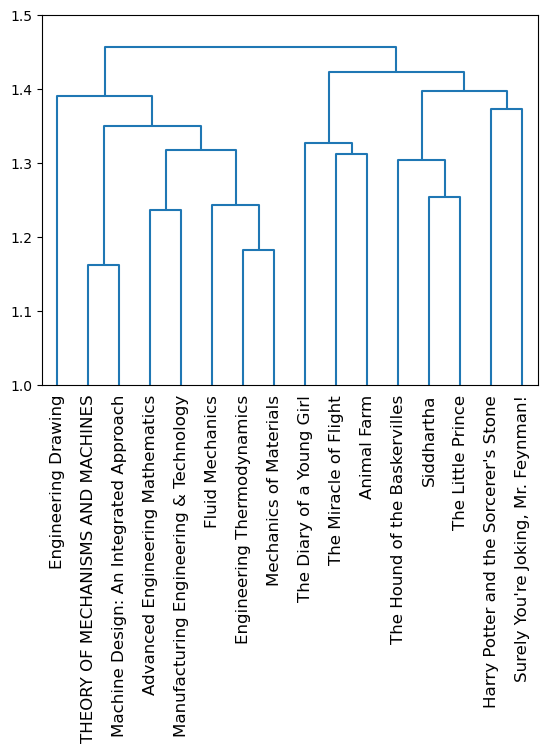

In [108]:
# create mergings matrix 
mergings = linkage(similarity_distance, method='complete')

# plot the dendrogram, using book title as label column
dendrogram_ = dendrogram(mergings,
               labels=[t for t in df["Title"]],
               leaf_rotation=90
)

plt.ylim(1.0, 1.5)
plt.show()

## Conclusion

At the topmost level, this NLP pipeline did a fantastic job of clustering my engineering books apart from literary works that I've read. Going down the dendogram, I am amazed how well the Engineering Thermodynamics has been separated away from Engineering Drawing and put between Fluid Mechanics and Mechanics of Materials!

One shortcoming is that Advanced Engineering Mathematics should have been also moved away at top level like Engineering Drawing was. The reason becomes apparant on close inspection of the book's description via `df['Details'][2]`. It doesn't have technical description of the table of contents i.e. chapter headings like that of Engineering Drawing.


**Further ideas:**
- I got another idea to go further with the above analysis: How about introducing books from my 'to-read' shelf? With that dendrogram, I could getter better sense of how my past interests influences my future interests. The dendrogram would be informative for me to know in what way the books I 'want to read' contribute to 'my knowledge' in terms of the books I have 'already read'.
- The second idea is as follows: How about utilizing topic modelling with Gensim to uncover labels for the nodes in the dendrogram? While the dendrogram branches do give a sense of how some books are more similar to a book than other, having a label at the nodes will make this even clearer. (Note: we can actually go even futher to label even the edges afterwards; though that would likely be done manually as I have limited understanding of computationally generating knowledge graphs).   